Classes: ['apple', 'banana', 'mixed', 'orange']
Using device: mps

=== Training with SGD, lr=0.01, lr_decay=0.5 ===
Epoch 1, Train Acc: 0.2625, Val Acc: 0.3792
Epoch 2, Train Acc: 0.4054, Val Acc: 0.4000
Epoch 3, Train Acc: 0.4750, Val Acc: 0.5917
Epoch 4, Train Acc: 0.6143, Val Acc: 0.5875
Epoch 5, Train Acc: 0.6768, Val Acc: 0.6250
Epoch 6, Train Acc: 0.7375, Val Acc: 0.7917
Epoch 7, Train Acc: 0.7857, Val Acc: 0.7833
Epoch 8, Train Acc: 0.7536, Val Acc: 0.8250
Epoch 9, Train Acc: 0.8107, Val Acc: 0.7458
Epoch 10, Train Acc: 0.8036, Val Acc: 0.8000
Epoch 11, Train Acc: 0.8214, Val Acc: 0.8375
Epoch 12, Train Acc: 0.8357, Val Acc: 0.8208
Epoch 13, Train Acc: 0.8571, Val Acc: 0.8375
Epoch 14, Train Acc: 0.8607, Val Acc: 0.8458
Epoch 15, Train Acc: 0.8482, Val Acc: 0.8375

Classification Report:
              precision    recall  f1-score   support

       apple       0.94      0.89      0.92        19
      banana       0.94      0.89      0.91        18
       mixed       0.57      0.

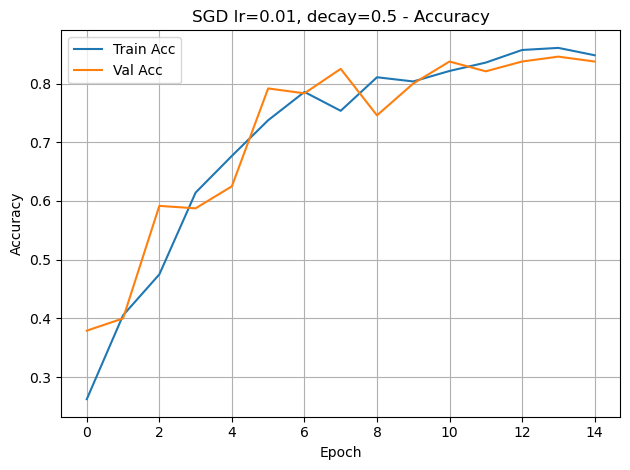

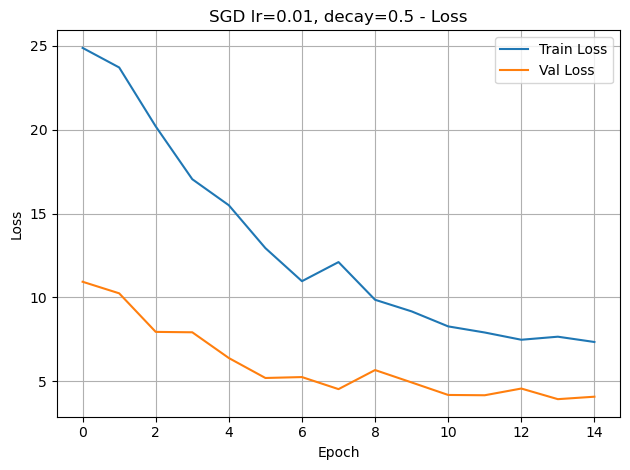


=== Training with Adam, lr=0.01, lr_decay=0.5 ===
Epoch 1, Train Acc: 0.2946, Val Acc: 0.4083
Epoch 2, Train Acc: 0.3786, Val Acc: 0.5667
Epoch 3, Train Acc: 0.4929, Val Acc: 0.6083
Epoch 4, Train Acc: 0.5232, Val Acc: 0.6125
Epoch 5, Train Acc: 0.5179, Val Acc: 0.4958
Epoch 6, Train Acc: 0.5625, Val Acc: 0.6542
Epoch 7, Train Acc: 0.5964, Val Acc: 0.5792
Epoch 8, Train Acc: 0.6250, Val Acc: 0.6167
Epoch 9, Train Acc: 0.6554, Val Acc: 0.7208
Epoch 10, Train Acc: 0.7375, Val Acc: 0.7333
Epoch 11, Train Acc: 0.7607, Val Acc: 0.7958
Epoch 12, Train Acc: 0.7946, Val Acc: 0.8042
Epoch 13, Train Acc: 0.7929, Val Acc: 0.8083
Epoch 14, Train Acc: 0.7929, Val Acc: 0.8000
Epoch 15, Train Acc: 0.8054, Val Acc: 0.8000

Classification Report:
              precision    recall  f1-score   support

       apple       0.94      0.89      0.92        19
      banana       0.88      0.83      0.86        18
       mixed       0.50      0.40      0.44         5
      orange       0.86      1.00      0.9

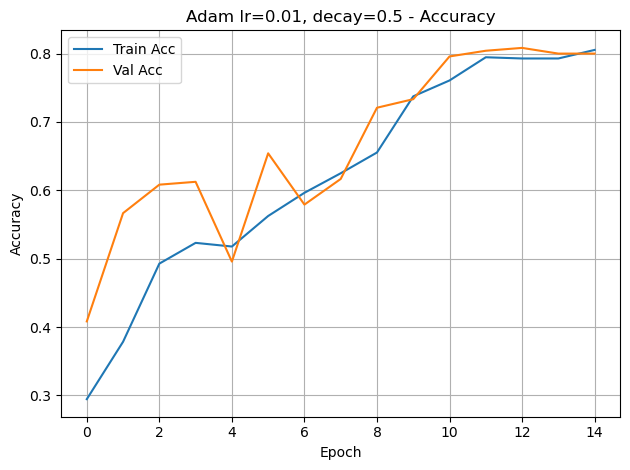

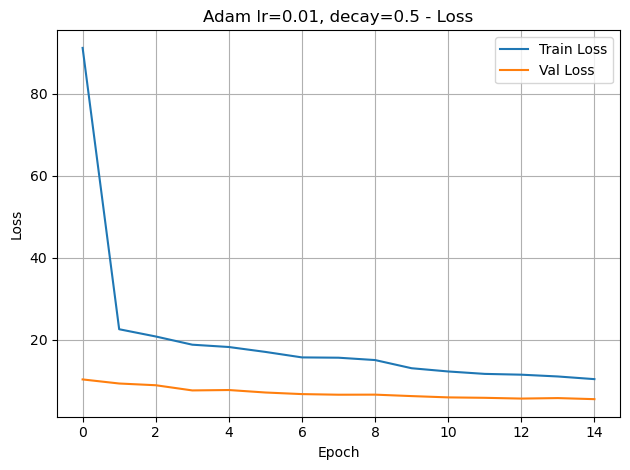


=== Training with AdamW, lr=0.005, lr_decay=0.9 ===
Epoch 1, Train Acc: 0.2946, Val Acc: 0.3375
Epoch 2, Train Acc: 0.4339, Val Acc: 0.5042
Epoch 3, Train Acc: 0.5464, Val Acc: 0.5917
Epoch 4, Train Acc: 0.6679, Val Acc: 0.6875
Epoch 5, Train Acc: 0.7339, Val Acc: 0.8000
Epoch 6, Train Acc: 0.7893, Val Acc: 0.7833
Epoch 7, Train Acc: 0.7821, Val Acc: 0.8042
Epoch 8, Train Acc: 0.8214, Val Acc: 0.7792
Epoch 9, Train Acc: 0.8071, Val Acc: 0.8375
Epoch 10, Train Acc: 0.8232, Val Acc: 0.8375
Epoch 11, Train Acc: 0.8696, Val Acc: 0.8000
Epoch 12, Train Acc: 0.8768, Val Acc: 0.8292
Epoch 13, Train Acc: 0.8375, Val Acc: 0.8708
Epoch 14, Train Acc: 0.8732, Val Acc: 0.8417
Epoch 15, Train Acc: 0.8589, Val Acc: 0.8708

Classification Report:
              precision    recall  f1-score   support

       apple       0.89      0.89      0.89        19
      banana       0.94      0.83      0.88        18
       mixed       0.57      0.80      0.67         5
      orange       0.94      0.94      0

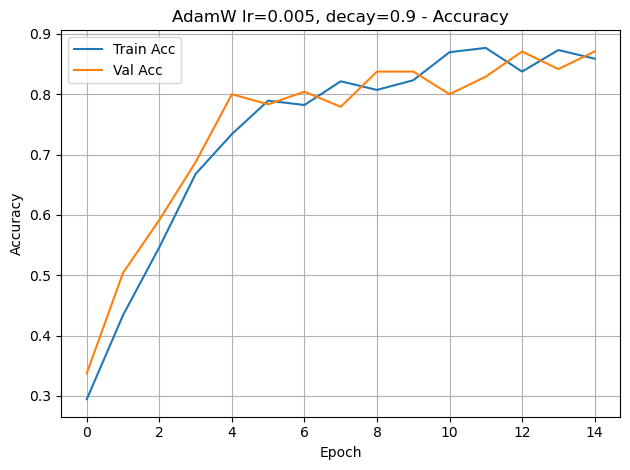

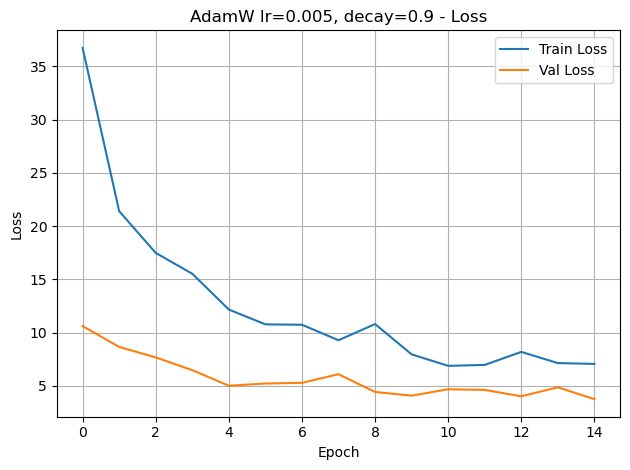


Saved training results to results/results_log_20250611_134607.csv
Saved classification reports to results/classification_reports_20250611_134607.txt


In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import random
from datetime import datetime
import matplotlib.pyplot as plt

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

class FruitCNN(nn.Module):
    def __init__(self):
        super(FruitCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * 12 * 12, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, 4)
        )

    def forward(self, x):
        return self.model(x)

def run_grid_search(train_path, test_path, batch_size=32, epochs=15, seed=42):
    set_seed(seed)

    transform_train = transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    transform_test = transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    train_data = ImageFolder(train_path, transform=transform_train)
    test_data = ImageFolder(test_path, transform=transform_test)

    train_size = int(0.7 * len(train_data))
    val_size = len(train_data) - train_size
    train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


    if torch.backends.mps.is_available():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    print("Classes:", train_data.classes)
    print("Using device:", device)

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    os.makedirs("results", exist_ok=True)
    csv_path = f"results/results_log_{timestamp}.csv"
    report_path = f"results/classification_reports_{timestamp}.txt"

    configurations = [
        ('SGD', 0.01, 0.5),
        ('Adam', 0.01, 0.5),
        ('AdamW', 0.005, 0.9)
    ]

    all_results = []
    with open(report_path, "w") as report_file:
        for opt_name, lr, lrd in configurations:
            print(f"\n=== Training with {opt_name}, lr={lr}, lr_decay={lrd} ===")
            model = FruitCNN().to(device)
            criterion = nn.CrossEntropyLoss()

            if opt_name == 'SGD':
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
            elif opt_name == 'Adam':
                optimizer = optim.Adam(model.parameters(), lr=lr)
            elif opt_name == 'AdamW':
                optimizer = optim.AdamW(model.parameters(), lr=lr)
            else:
                raise ValueError(f"Unknown optimizer: {opt_name}")

            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=lrd)

            train_acc, val_acc, train_loss, val_loss = [], [], [], []

            for epoch in range(epochs):
                model.train()
                correct, total, running_loss = 0, 0, 0.0
                for images, labels in train_loader:
                    images, labels = images.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)
                train_acc.append(correct / total)
                train_loss.append(running_loss)

                model.eval()
                val_correct, val_total, val_running_loss = 0, 0, 0.0
                with torch.no_grad():
                    for val_images, val_labels in val_loader:
                        val_images, val_labels = val_images.to(device), val_labels.to(device)
                        val_outputs = model(val_images)
                        val_loss_batch = criterion(val_outputs, val_labels)
                        val_running_loss += val_loss_batch.item()
                        _, val_preds = torch.max(val_outputs, 1)
                        val_total += val_labels.size(0)
                        val_correct += (val_preds == val_labels).sum().item()
                val_acc.append(val_correct / val_total)
                val_loss.append(val_running_loss)
                scheduler.step()

                print(f"Epoch {epoch+1}, Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

            model.eval()
            y_true, y_pred = [], []
            with torch.no_grad():
                for images, labels in test_loader:
                    images = images.to(device)
                    outputs = model(images)
                    _, preds = torch.max(outputs, 1)
                    y_pred.extend(preds.cpu().numpy())
                    y_true.extend(labels.numpy())

            report = classification_report(y_true, y_pred, target_names=train_data.classes)
            print("\nClassification Report:")
            print(report)

            report_file.write(
                f"=== Optimizer: {opt_name}, LR: {lr}, Decay: {lrd} ===\n{report}\n\n"
            )

            all_results.append({
                'optimizer': opt_name,
                'lr': lr,
                'lr_decay': lrd,
                'final_train_acc': train_acc[-1],
                'final_val_acc': val_acc[-1],
                'final_train_loss': train_loss[-1],
                'final_val_loss': val_loss[-1]
            })

            # Plot Accuracy
            plt.figure()
            plt.plot(train_acc, label='Train Acc')
            plt.plot(val_acc, label='Val Acc')
            plt.title(f'{opt_name} lr={lr}, decay={lrd} - Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            # Plot Loss
            plt.figure()
            plt.plot(train_loss, label='Train Loss')
            plt.plot(val_loss, label='Val Loss')
            plt.title(f'{opt_name} lr={lr}, decay={lrd} - Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            del model
            torch.cuda.empty_cache()

    pd.DataFrame(all_results).to_csv(csv_path, index=False)
    print(f"\nSaved training results to {csv_path}")
    print(f"Saved classification reports to {report_path}")

# Run
run_grid_search(
    train_path="../train",
    test_path="../test",
    batch_size=32,
    epochs=15,
    seed=42
)
